In [2]:
import os
import glob
import lzma
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
import random 
import torch 

In [62]:
#read all preditions
all_preds = {}
all_models = []
dirname = 'sensitivity_bond_20240908'
numfile = 0 
for root, dirs, files in os.walk(dirname):
        for file in files:
            if file.endswith('.xz'):
                numfile += 1
                filepath = os.path.join(root, file)
                df = pd.read_csv(filepath)
                all_preds[file] = pd.read_csv(filepath)
                all_models.append(file)
                if numfile>10:
                     break 
all_preds[all_models[0]].head()

,FundId,Month,future_ab_monthly_return,future_ab_monthly_return_pred
0,FSUSA00006,1995-05-31,-0.000241,0.001878
1,FSUSA00008,1995-05-31,-0.000880,0.002135
2,FSUSA0000A,1995-05-31,-0.001527,0.001732
3,FSUSA0000O,1995-05-31,-0.002830,0.001663
4,FSUSA0000Z,1995-05-31,0.000777,0.003568


In [4]:
def decile_plot(selected_model=all_models[0], ensemble=True):
    if ensemble: 
        preds_list = []
        for model in all_models:
            model_pred = all_preds[model]['future_ab_monthly_return_pred'].values
            preds_list.append(model_pred)
        final_preds = np.mean(np.array(preds_list), axis=0)
        df = all_preds[selected_model]
        df['future_ab_monthly_return_pred'] = final_preds
    else:
        df = all_preds[selected_model]
    #decile plot 
    df['rank'] = df.groupby('Month')['future_ab_monthly_return_pred'].rank(method='first')
    df['decile'] = df.groupby(['Month'], group_keys=False)['rank'].apply(lambda x: pd.qcut(x, 10, labels=False))
    df_monthly_return = calculate_month_return(df)
    df_monthly_return['timestep']=pd.to_datetime(df_monthly_return['timestep'])
    plot_returns(df_monthly_return, method='sum', pred_weight=True, savedir=None)
    return df_monthly_return
def calculate_month_return(df, predcol, decilecol):
    #df-> [FundId, month, decile, prediciton]
    #return df -> [timestep, decile, return_equal, return_pred]
    #return_equal -> equally weighted monthly return 
    #return_pred -> predicion weighted monthly return 
    results = []
    for timestep in df['Month'].unique():
        df_timestep = df[df['Month'] == timestep]
        for decile in df_timestep[decilecol].unique():
            df_decile = df_timestep[df_timestep[decilecol] == decile]
            return_equal = df_decile['future_ab_monthly_return'].mean() #equal weight
            #predition weight 
            month_returns = torch.tensor(df_decile['future_ab_monthly_return'].values, dtype=torch.float32)
            month_predictions = torch.tensor(df_decile[predcol].values, dtype=torch.float32)
            weights = month_predictions.clone()
            if decile >= 5:
                weights -= torch.min(month_predictions)
            elif decile < 5:
                weights -= torch.max(month_predictions)
            return_pred = torch.sum(month_returns * weights) / torch.sum(weights)
            #add to output 
            results.append({
                'timestep': timestep,
                'decile': decile,
                'return_equal': return_equal,
                'return_pred': return_pred.item()
            })
    result_df = pd.DataFrame(results)
    return result_df

In [6]:
def plot_returns(df, method, cumulative=True, pred_weight = False, savedir= None):
    #df -> [timestep, decile, return_equal, return_pred]
    # for each decile, plot the return across all timesteps
    plt.figure(figsize=(10, 6))
    for i in range (10):
        df_decile = df[df['decile'] == i].copy()
        df_decile = df_decile.sort_values('timestep')
        if cumulative and method == 'sum': 
            df_decile['cumulative_return_equal'] = df_decile['return_equal'].cumsum()
            df_decile['cumulative_return_pred'] = df_decile['return_pred'].cumsum()
        elif cumulative and method == 'logsum':
            df_decile['cumulative_return_equal'] = np.exp(np.log1p(df_decile['return_equal']).cumsum()) - 1
            df_decile['cumulative_return_pred'] = np.exp(np.log1p(df_decile['return_pred']).cumsum()) - 1
        else:
            df_decile['cumulative_return_equal'] = df_decile['return_equal']
            df_decile['cumulative_return_pred'] = df_decile['return_pred']
        if pred_weight:
            plt.plot(df_decile['timestep'], df_decile['cumulative_return_pred'],  label=f'Decile {i}')
        else:
            plt.plot(df_decile['timestep'], df_decile['cumulative_return_equal'], label=f'Decile {i}')
    plt.xticks(rotation=45)
    plt.xlabel('Year')
    plt.ylabel('Cumulative Abnormal Return' if cumulative else 'Return')
    plt.title('Cumulative Abnormal Returns Over Time' if cumulative else 'Abnormal Returns Over Time')
    plt.suptitle('Prediction-weighted' if pred_weight else 'Equally-weighted', fontsize=9, y=0.87)
    if savedir is not None:
        plt.savefig(savedir+"cumulative_abnormal_return.png", dpi=300, bbox_inches='tight')
    plt.ylim(-1, 1)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

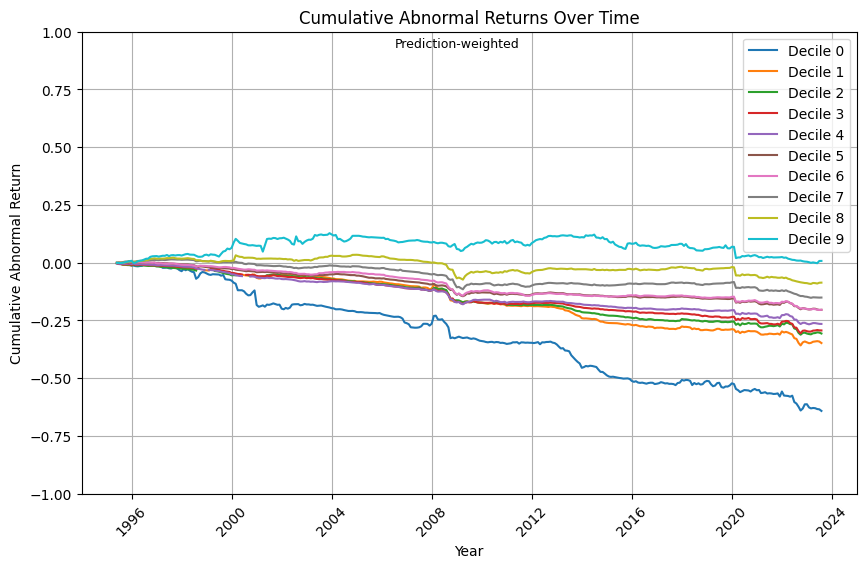

,timestep,decile,return_equal,return_pred
0,1995-05-31,6,-0.001545,-0.001680
1,1995-05-31,7,-0.000725,-0.000032
2,1995-05-31,9,-0.000973,-0.000311
3,1995-05-31,8,-0.000336,-0.000387
4,1995-05-31,4,-0.002788,-0.002738
...,...,...,...,...
3385,2014-05-31,2,-0.001667,-0.001796
3386,2014-05-31,6,-0.000990,-0.000765
3387,2014-05-31,5,-0.001289,-0.000921
3388,2014-05-31,7,-0.001197,-0.001097


In [11]:
decile_plot(ensemble=False)

In [6]:
df_preds = pd.DataFrame()
for fileid in tqdm(range(len(all_models))):
    df_ = all_preds[all_models[fileid]][['FundId','Month', 'future_ab_monthly_return_pred']]
    df_.set_index(['Month', 'FundId'], inplace=True)
    df_.columns = [fileid]
    df_preds = pd.concat([df_preds, df_], axis=1)
df_np = df_preds.to_numpy()
M, N = 4, 100
inds = np.random.choice(range(len(all_models)), size=(M, N))
vals = np.mean(df_np[:, inds], axis=1)
vals.shape

100%|██████████| 11/11 [00:01<00:00,  9.97it/s]


(438245, 100)

In [51]:
#get deciles and weighted predictions for each N
df_truth = all_preds[all_models[0]][['FundId','Month', 'future_ab_monthly_return']].set_index(['Month', 'FundId'])
df_vals = pd.DataFrame(vals, index=df_truth.index, columns=[f'pred_{i}' for i in range(100)])
df_combined = pd.concat([df_truth, df_vals], axis=1).reset_index()
df_returns = pd.DataFrame()
for i in tqdm(range (N)):
    curr_column = f'pred_{i}'
    df_combined[f'decile{i}'] = df_combined.groupby(['Month'], group_keys=False)[curr_column].apply(lambda x: pd.qcut(x, 10, labels=False))
    df_monthly_return = calculate_month_return(df_combined, predcol = curr_column, decilecol = f'decile{i}').set_index('timestep')
    df_returns[f'pred_weighted_return{i}'] = df_monthly_return['return_pred']
    df_returns[f'decile{i}'] = df_monthly_return['decile']
df_combined.head()


 50%|█████     | 50/100 [04:37<05:01,  6.02s/it]/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_29236/1490548647.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_returns[f'pred_weighted_return{i}'] = df_monthly_return['return_pred']
/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_29236/1490548647.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_returns[f'decile{i}'] = df_monthly_return['decile']
 51%|█████     | 51/100 [04:43<04:55,  6.04s/it]/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ip

,Month,FundId,future_ab_monthly_return,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,...,decile90,decile91,decile92,decile93,decile94,decile95,decile96,decile97,decile98,decile99
0,1995-05-31,FSUSA00006,-0.000241,0.000356,0.001533,-0.000918,-0.001172,-0.000103,0.001693,0.000382,...,6,3,6,5,2,3,4,3,4,6
1,1995-05-31,FSUSA00008,-0.000880,0.000695,0.000937,0.000141,0.000361,0.000316,0.000531,0.000240,...,7,8,6,6,6,8,7,7,8,7
2,1995-05-31,FSUSA0000A,-0.001527,0.000822,0.000932,-0.000335,-0.000492,0.000485,0.000799,0.000480,...,6,5,6,6,6,6,6,6,6,7
3,1995-05-31,FSUSA0000O,-0.002830,-0.000815,0.000939,-0.003085,-0.003476,-0.001158,0.000942,-0.000719,...,3,0,5,1,0,0,0,0,0,2
4,1995-05-31,FSUSA0000Z,0.000777,0.001190,0.002203,0.000741,0.000254,0.001184,0.001802,0.001315,...,9,8,8,8,8,8,7,8,8,9


In [52]:
df_returns.head()

,pred_weighted_return0,decile0,pred_weighted_return1,decile1,pred_weighted_return2,decile2,pred_weighted_return3,decile3,pred_weighted_return4,decile4,...,pred_weighted_return95,decile95,pred_weighted_return96,decile96,pred_weighted_return97,decile97,pred_weighted_return98,decile98,pred_weighted_return99,decile99
timestep,,,,,,,,,,,,,,,,,,,,,
1995-05-31,-0.001757,4,-0.000091,7,-0.001618,4,-0.002312,4,-0.001612,4,...,-0.002631,3,-0.001466,4,-0.002222,3,-0.002312,4,-0.000621,6
1995-05-31,-0.000195,6,-0.000599,6,-0.000182,7,0.000179,8,-0.000607,7,...,-0.000819,8,-0.000314,7,-0.000058,7,0.000179,8,-0.000584,7
1995-05-31,-0.000520,7,-0.000755,8,-0.000330,6,-0.000567,6,-0.005075,0,...,-0.000701,6,0.000162,6,-0.000164,6,-0.000567,6,-0.002065,2
1995-05-31,-0.004846,0,-0.002141,2,-0.005793,0,-0.004384,0,0.000039,9,...,-0.004268,0,-0.003285,0,-0.004595,0,-0.004384,0,0.000017,9
1995-05-31,-0.001331,8,-0.002609,3,-0.000397,9,-0.003092,1,-0.000212,6,...,-0.002533,1,-0.003370,2,-0.000589,8,-0.003092,1,-0.004054,1


In [ ]:
#calculate 25th, median and 75th 
cols = [f'pred_weighted_return{i}' for i in range(100)]
df_returns['25th_percentile'] = df[cols].quantile(0.25, axis=1)
df_returns['median'] = df[cols].median(axis=1)
df_returns['75th_percentile'] = df[cols].quantile(0.75, axis=1)

In [60]:
def check_chronological_order(df):
    # Ensure 'Month' is in datetime format
    df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m-%d', errors='coerce')
    
    # Loop through the 'Month' column and check for the first violation
    for i in range(1, len(df)):
        if df['Month'].iloc[i] < df['Month'].iloc[i - 1]:
            print(f"Chronological order breaks at row {i}, Month: {df['Month'].iloc[i]}")
            return False
    
    # If no violation found, the column is in chronological order
    print("The 'Month' column is in chronological order.")
    return True

In [57]:
df = pd.DataFrame()
for i in tqdm(range (N)):
    df_truth = all_preds[all_models[0]][['FundId','Month', 'future_ab_monthly_return']].set_index(['Month', 'FundId'])
    df_vals = pd.DataFrame(vals[:,i], index=df_truth.index, columns=['pred'])
    df_combined = pd.concat([df_truth, df_vals], axis=1).reset_index()
    df_combined['N']=i
    df = pd.concat([df, df_combined], axis=0)
check_chronological_order(df)

100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


The 'Month' column is NOT in chronological order.


False

In [61]:
check_chronological_order(all_preds[all_models[0]])
all_preds[all_models[0]].to_csv('og.csv')

Chronological order breaks at row 375505, Month: 2014-06-30 00:00:00


In [22]:
df['rank'] = df.groupby(['Month', 'N'])['pred'].rank(method='first')
df['decile'] = df.groupby(['Month', 'N'])['rank'].transform(lambda x: pd.qcut(x, 10, labels=False))
#keep only the top and bottom decile 
df = df[df['decile'].isin([0, 9])]

In [55]:
df_to_plot = pd.DataFrame()
for decile in df['decile'].unique():
    df_weight = df.loc[df['decile'] == decile].copy()
    df_weight.to_csv('weight.csv')
    df_weight= df_weight.groupby(['Month', 'N'])['future_ab_monthly_return'].mean()
    decile_np = df_weight.unstack().to_numpy()
    p75 = np.percentile(decile_np, 75, axis=1)
    p25 = np.percentile(decile_np, 25, axis=1)
    median = np.median(decile_np, axis=1)
    df_summary = pd.DataFrame()
    df_summary['timestep'] = pd.to_datetime(all_preds[all_models[0]]['Month'].unique())
    df_summary['decile'] = decile
    df_summary['25th'] = p25
    df_summary['75th'] = p75
    df_summary['median'] = median
    df_to_plot = pd.concat([df_to_plot, df_summary], axis=0)
df_to_plot.to_csv('dftoplot.csv')

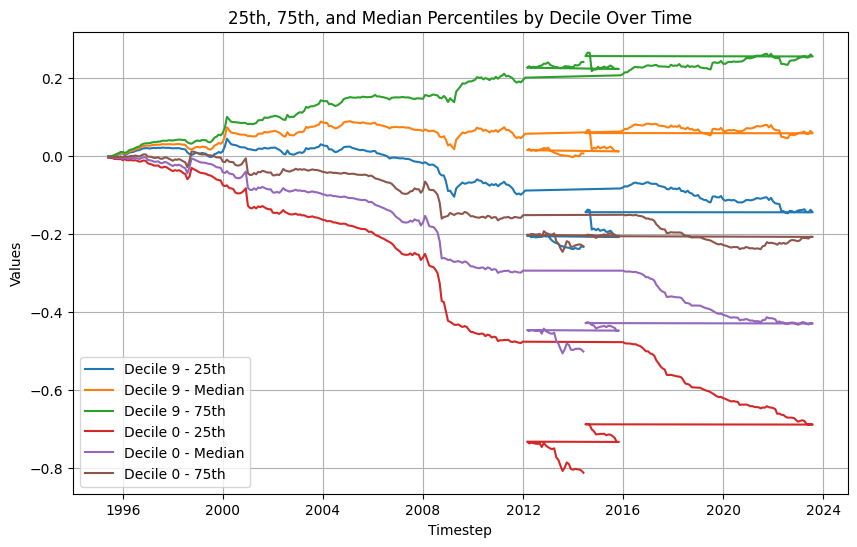

In [51]:
#plot 
plt.figure(figsize=(10, 6))
for decile in df_to_plot['decile'].unique():
    decile_df = df_to_plot.loc[df_to_plot['decile'] == decile].copy()
    decile_df['cumulative_return_median'] = decile_df['median'].cumsum()
    decile_df['cumulative_return_25'] = decile_df['25th'].cumsum()
    decile_df['cumulative_return_75'] = decile_df['75th'].cumsum()
    plt.plot(decile_df['timestep'], decile_df['cumulative_return_25'], label=f'Decile {decile} - 25th')
    plt.plot(decile_df['timestep'], decile_df['cumulative_return_median'], label=f'Decile {decile} - Median')
    plt.plot(decile_df['timestep'], decile_df['cumulative_return_75'], label=f'Decile {decile} - 75th')
plt.title('25th, 75th, and Median Percentiles by Decile Over Time')
plt.xlabel('Timestep')
plt.ylabel('Values')
plt.legend(loc='best')
plt.grid(True)
plt.show()